In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Bidirectional
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Load the dataset containing both normal and DDoS traffic
data = pd.read_csv("normal.csv")

# 2. Separate BENIGN (normal) data for training
train_data = data[data[' Label'] == 'BENIGN']

# 3. Drop the label column if it exists and keep only feature columns for model input
if ' Label' in train_data.columns:
    train_data = train_data.drop(columns=[' Label'])

# 4. Check for invalid values (NaN, infinity) and handle them
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data = train_data.dropna()  # Drop any rows with NaN values

# 5. Standardize the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data)

# Calculate the number of samples and features
num_samples = X_train_scaled.shape[0]
num_features = X_train_scaled.shape[1]

# Set the number of timesteps (you can adjust this value)
timesteps = 50

# Ensure that the number of samples is divisible by the number of timesteps
# If not, trim the dataset to make it divisible
trimmed_samples = num_samples - (num_samples % timesteps)

# Trim the dataset to make it divisible by the timesteps
X_train_trimmed = X_train_scaled[:trimmed_samples]

# Reshape the dataset into 3D: [samples, timesteps, features]
X_train_reshaped = X_train_trimmed.reshape((trimmed_samples // timesteps, timesteps, num_features))

print("New shape for LSTM input:", X_train_reshaped.shape)



New shape for LSTM input: (9768, 10, 78)


In [23]:
from tensorflow.keras.layers import Dropout

# Ensure that you're using X_train_reshaped for defining the input shape
model = Sequential([
    Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),  # timesteps and features
    
    # First bidirectional LSTM layer
    Bidirectional(LSTM(512, activation='relu', return_sequences=True)),
    Dropout(0.4),
    
    # Second bidirectional LSTM layer
    Bidirectional(LSTM(256, activation='relu', return_sequences=True)),
    Dropout(0.3),
    
    # Third bidirectional LSTM layer
    Bidirectional(LSTM(128, activation='relu', return_sequences=False)),
    RepeatVector(X_train_reshaped.shape[1]),  # timesteps
    
    # Fourth bidirectional LSTM layer
    Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
    Dropout(0.3),
    
    # Fifth bidirectional LSTM layer
    Bidirectional(LSTM(256, activation='relu', return_sequences=True)),
    
    # Adding TimeDistributed layer to apply Dense across each timestep
    TimeDistributed(Dense(128, activation='relu')),
    Dropout(0.3),
    
    # Final TimeDistributed Dense layer for reconstruction
    TimeDistributed(Dense(X_train_reshaped.shape[2]))  # number of features
])


# Compile the model with Huber loss
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

model.summary()

# 9. Use Early Stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 10. Train the model on benign data only (use X_train_reshaped for LSTM)
history = model.fit(
    X_train_reshaped, X_train_reshaped,  # Use 3D reshaped data
    epochs=100, 
    batch_size=64, 
    validation_split=0.2,  # Splitting the reshaped 3D data
    shuffle=True, 
    callbacks=[early_stopping]  # Use early stopping to prevent overfitting
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_28 (Bidirectional)     │ (None, 10, 512)             │         686,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 10, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_29 (Bidirectional)     │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_7 (RepeatVector)       │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_30 (Bidirectional)     │ (None, 10, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_31 (Bidirectional)     │ (None, 10, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 10, 78)              │          40,014 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,827,342 (10.79 MB)

 Trainable params: 2,827,342 (10.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 48s 154ms/step - loss: 0.1391 - val_loss: 0.0912
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.0787 - val_loss: 0.0855
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 0.0719 - val_loss: 0.0828
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 0.0682 - val_loss: 0.0797
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - loss: 0.0628 - val_loss: 0.0774
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.0616 - val_loss: 0.0766
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.0600 - val_loss: 0.0745
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 0.0570 - val_loss: 0.0730
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.0557 - val_loss: 0.0720
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.0562 - val_loss: 0.0691
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - loss: 0.0520 - val_loss: 0.0700
Epoch 12/

306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step
Dynamic threshold for anomaly detection:  0.3677426746818697


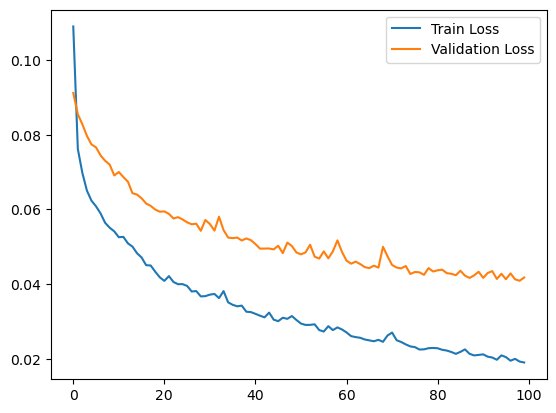

In [24]:
# Reshape X_train_scaled to 3D as required by the LSTM
X_train_scaled_reshaped = X_train_scaled[:trimmed_samples].reshape((trimmed_samples // timesteps, timesteps, num_features))

# Predict on the reshaped data
X_train_pred = model.predict(X_train_scaled_reshaped)

# Calculate Mean Squared Error (MSE) between original and predicted
train_mse = np.mean(np.power(X_train_scaled_reshaped - X_train_pred, 2), axis=(1, 2))

# Set the threshold dynamically based on the 95th percentile of normal reconstruction error
threshold = np.percentile(train_mse, 95)


print("Dynamic threshold for anomaly detection: ", threshold)

# 11. Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [25]:
# 12. Load the second dataset containing both normal and DDoS traffic
test_data = pd.read_csv("DDOS_attack.csv")

# 13. Replace invalid values and drop NaNs
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data = test_data.dropna()

# 14. Keep a copy of original labels for performance evaluation later
test_labels = test_data[' Label'].copy()
test_data_features = test_data.drop(columns=[' Label'])

# 15. Standardize the test dataset using the same scaler
X_test_scaled = scaler.transform(test_data_features)

# 16. Reshape test data for LSTM input
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 17. Predict and calculate reconstruction error for the second dataset
X_test_pred = model.predict(X_test_scaled)

# 18. Calculate the Mean Squared Error (MSE) between original and reconstructed data
# Calculate reconstruction error on the test set
test_mse = np.mean(np.power(X_test_scaled - X_test_pred, 2), axis=(1, 2))

# 20. Identify anomalies: MSE greater than threshold are labeled as anomalies
# Detect anomalies: reconstruction errors greater than the threshold are anomalies
anomalies = test_mse > threshold

# Create a new DataFrame to analyze the results
test_results = pd.DataFrame({'Label': test_labels, 'Anomaly': anomalies, 'Reconstruction Error': test_mse})

# Encode BENIGN as 0 and attacks as 1 for evaluation
test_results['True_Label'] = (test_results['Label'] != 'BENIGN').astype(int)

# Evaluate model performance
print("Confusion Matrix:\n", confusion_matrix(test_results['True_Label'], test_results['Anomaly']))
print("Classification Report:\n", classification_report(test_results['True_Label'], test_results['Anomaly']))
print("Accuracy Score: ", accuracy_score(test_results['True_Label'], test_results['Anomaly']))

7054/7054 ━━━━━━━━━━━━━━━━━━━━ 94s 13ms/step
Confusion Matrix:
 [[84454 13232]
 [46548 81477]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.86      0.74     97686
           1       0.86      0.64      0.73    128025

    accuracy                           0.74    225711
   macro avg       0.75      0.75      0.74    225711
weighted avg       0.77      0.74      0.73    225711

Accuracy Score:  0.7351480432943012
